In [1]:
import pandas as pd
import os.path as op
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import seaborn as sns
import os
from numrisk.utils.data import Subject

bids_folder = '/Volumes/mrenkeED/data/ds-dnumrisk'
subs= [int(f[4:]) for f in listdir(bids_folder) if f[0:3] == 'sub']
pati_save = '/Users/mrenke/data/ds-dnumrisk/interim_sum_data'

target_folder = op.join(bids_folder, 'derivatives', 'cogmodels')
subjects = [Subject(sub, bids_folder) for sub in subs]

group_mapping = pd.read_csv('/Users/mrenke/data/ds-dnumrisk/interim_sum_data/group_assignment_sub1-42.csv').set_index('subject')

data_variants = ['full', 'run_123', 'run_456'] #



In [ ]:
import bambi as bmb
import arviz as az


for split_data in data_variants:
    if split_data == 'full':
        runs = range(1, 7)
    if split_data == 'run_123':
        runs = range(1, 4)
    elif split_data == 'run_456':
        runs = range(4,7)

    behavior = [s.get_behavior_magjudge(runs = runs) for s in subjects]
    df =  pd.concat(behavior).sort_index(0).dropna()
    df['choice'] = df['chose_n2']
    df['x'] = df['log(n2/n1)']
    
    probit_model = bmb.Model('choice ~ 0 + x + (x|subject)', data=df.reset_index(), family='bernoulli', link='probit')

    trace = probit_model.fit()

    fn = op.join(target_folder, f'bmb_model-{split_data}_trace.netcdf')
    az.to_netcdf(trace,fn)

# 0 divergences for all fittings!!!

In [7]:
from utils import extract_intercept_gamma
import arviz as az
import bambi as bmb

df_slopes = []
for split_data in data_variants:
    if split_data == 'full':
        runs = range(1, 7)
    if split_data == 'run_123':
        runs = range(1, 4)
    elif split_data == 'run_456':
        runs = range(4,7)

    behavior = [s.get_behavior_magjudge(runs = runs) for s in subjects]
    df =  pd.concat(behavior).sort_index(0).dropna()
    df['choice'] = df['chose_n2']
    df['x'] = df['log(n2/n1)']
    
    probit_model = bmb.Model('choice ~ 0 + x + (x|subject)', data=df.reset_index(), family='bernoulli', link='probit')

    idata_probit = az.from_netcdf(op.join(target_folder, f'bmb_model-{split_data}_trace.netcdf'))
    intercept, gamma = extract_intercept_gamma(idata_probit, probit_model, df)
    slopes = gamma.stack(['chain','draw']).groupby('subject').mean()
    df_slopes.append(slopes)

df_slopes = pd.concat(df_slopes, keys=data_variants, names=['data','subject'])
df_slopes.to_csv(op.join(pati_save, 'gammas-bambi_sub1-42_data-variants.csv'))

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_96691/403140897.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  df =  pd.concat(behavior).sort_index(0).dropna()
/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_96691/403140897.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  df =  pd.concat(behavior).sort_index(0).dropna()
/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_96691/403140897.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  df =  pd.concat(behavior).sort_index(0).dropna()


## load in 

In [2]:
df_slopes = pd.read_csv(op.join(pati_save, 'gammas-bambi_sub1-42_data-variants.csv'))
df_slopes = df_slopes.set_index(['data','subject'])


In [3]:
df_slopes.head()

gamma
data subject          
full 1        4.316913
     2        3.258281
     3        2.774678
     4        4.573071
     5        3.428308

Text(0.5, 1.0, ' r=0.44, p= 0.00381')

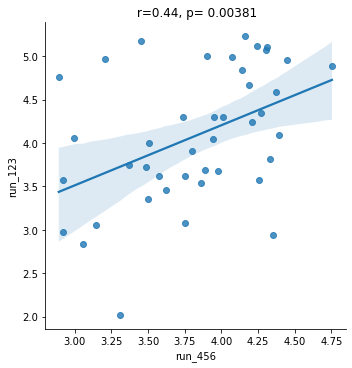

In [5]:
import pingouin

temp = df_slopes['gamma'].unstack('data')

var1 = 'run_456'#'full' #'run_456' # 
var2 = 'run_123'
cor = pingouin.corr(temp[var1],temp[var2])
r_ = np.round(cor['r'][0], 2)
p = np.round(cor['p-val'][0], 5)

sns.lmplot(data=temp.reset_index(), x=var1,y=var2)
plt.title(f' r={r_}, p= {p}') 

In [8]:
import pingouin
df = df_slopes['gamma'].unstack('data')

for split_data in data_variants:
    trr = pingouin.cronbach_alpha(data=df.drop(split_data,axis=1))
    print(f'{split_data} -removed, {trr[0]:0.2f}')

full -removed, 0.57
run_123 -removed, 0.89
run_456 -removed, 0.91


# comp. with r-decoding

In [29]:
df_rs = pd.read_csv(op.join(pati_save, 'rs_sub1-42_data-variants.csv'))
df_rs = df_rs.set_index(['data','subject']).xs('full',0,'data')


In [31]:
df_comb = df_slopes.xs('full',0,'data').join(df_rs)

Text(0.5, 1.0, 'r=-0.1, p= 0.55604')

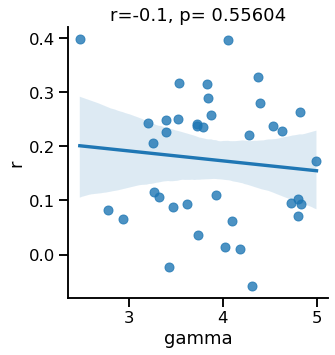

In [35]:
sns.set_context('talk')
var1 = 'gamma' #'run_456' # 
var2 = 'r'
cor = pingouin.corr(df_comb[var1],df_comb[var2])
r_ = np.round(cor['r'][0], 2)
p = np.round(cor['p-val'][0], 5)

sns.lmplot(data=df_comb, x=var1,y=var2)
plt.title(f'r={r_}, p= {p}') 

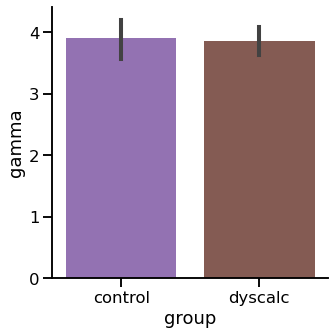

In [40]:
temp = df_comb.join(group_mapping)
temp['group']= np.where(temp['group'] == 0, 'control', 'dyscalc')

palette = sns.color_palette()[4:]

sns.catplot(data =temp ,x='group',y='gamma',kind='bar', palette=palette)